# WaveNet Starter using RAW EEG Features!
This notebook is a WaveNet starter for Kaggle's Brain comp. It achieves `CV 0.91` and `LB 0.66`. Note that submitting train means achieves `CV 1.26` and `LB 0.97` [[here][1]]. So this notebook's WaveNet is successfully learning to predict brain events from raw EEG waveforms!

This model only uses two features. We can engineer more features and/or modify the model architecture to improve CV score and LB score. Furthermore we can build 1 model which inputs both spectrogram images and eeg waveforms. The two EEG features in this notebook are:
* feature 1 : `Fp1 minus O1`
* feature 2 : `Fp2 minus O2`

Feature 1 is the beginning of the montage chains `LL` and `LP` minus the ending of montage `LL` and `LP`. And feature 2 is the beginning of the montage chains `RL` and `RP` minus the ending of montage `RL` and `RP`.
![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/montage.png)

# UPDATE
In version 7 and 8, we add more features and update the model architecture to evaluate each montage chain separately and then concatenate the features. This new architecture is motivated by the discovery of a better formula to utilize EEG explained in discussion [here][2]

* Version 5,6: Use 2 features - CV 0.91 LB 0.66
* Version 7,8: Use 8 features grouped as 4 chains. Downsample time 5x - **CV 0.81 LB 0.53**, wow!

We train our new model in version 7, then save model weights. Then load model into version 8 to submit to LB.

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/wave-model.png)

# Train and Infer Tricks
We train the fold models in version 7 of the notebook and submit to Kaggle LB in version 8 of the notebook. This makes submission faster because we train the fold models for 30 minutes in version 7 then save them. In version 8, we just load the models without needing to retrain models during Kaggle submit. (And we train our old model in 5 annd submit in 6).

Version 4 uses `1xP100` GPU with full precision and takes 1 hour to train 5 folds 5 epochs of WaveNet. Version 5 uses `2xT4` GPU with mixed precision and takes 30 minutes to train 5 folds 5 epochs of WaveNet. 

[1]: https://www.kaggle.com/code/seshurajup/eda-train-csv
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760

Data description
[https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010](http://)
[https://www.kaggle.com/code/seshurajup/eda-train-csv](http://)

Ref:
[https://keras.io/examples/timeseries/eeg_signal_classification/](http://)

# Load Train Data

In [4]:
import pandas as pd, numpy as np, os
import matplotlib.pyplot as plt

train = pd.read_csv('./kaggle/input/hms-harmful-brain-activity-classification/train.csv')
print( train.shape )
display( train.head() )

# CHOICE TO CREATE OR LOAD EEGS FROM NOTEBOOK VERSION 1
CREATE_EEGS = False
TRAIN_MODEL = False

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [5]:
#shift vote to probability
train['vote_number'] = train['seizure_vote']+train['lpd_vote']+train['gpd_vote']+train['lrda_vote']+train['grda_vote']+train['other_vote']
train['seizure'] = train['seizure_vote']/train['vote_number']
train['lpd'] = train['lpd_vote']/train['vote_number']
train['gpd'] = train['gpd_vote']/train['vote_number']
train['lrda'] = train['lrda_vote']/train['vote_number']
train['grda'] = train['grda_vote']/train['vote_number']
train['other'] =train['other_vote']/train['vote_number']

In [7]:
train.to_csv('./kaggle/input/processed_data/train.csv', index=False)

In [20]:
train_no_duplicate = train.drop_duplicates(subset="eeg_id")

In [21]:
eeg_id = train_no_duplicate['eeg_id'].to_list()

In [28]:
train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,vote_number,seizure,lpd,gpd,lrda,grda,other
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,...,0,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,...,3,0,0,3,0.0,0.0,0.0,1.0,0.0,0.0


In [32]:
id = eeg_id[1]
train[train['eeg_id']==id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,...,lrda_vote,grda_vote,other_vote,vote_number,seizure,lpd,gpd,lrda,grda,other
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,...,0,1,5,11,0.0,0.0,0.454545,0.0,0.090909,0.454545
10,2277392603,1,2.0,924234,1,2.0,134339127,30539,GPD,0,...,0,1,5,11,0.0,0.0,0.454545,0.0,0.090909,0.454545


# Raw EEG Features

In [16]:
df = pd.read_parquet('./kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1002858110.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print( list(FEATS) )

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']


In [6]:
def eeg_from_parquet(parquet_path, 
                     display=False, 
                     fs=200,
                     FEATS=['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']):
    eeg_df = pd.read_parquet(parquet_path, columns=FEATS)
    if display: 
        plt.figure(figsize=(10,5))
        offset = 0
    eeg_len = eeg_df.shape[0]
    data = {}
    for j,col in enumerate(FEATS):
        # FILL NAN
        x = eeg_df[col].values.astype('float32')
        m = np.nanmean(x)
        if np.isnan(x).mean()<1: 
            x = np.nan_to_num(x,nan=m) # fill nan with mean
        else: 
            x[:] = 0  
        data[col] = {
            'signal':x,
            'fs':fs,
        }
        if display: 
            if j!=0:
                offset += x.max()
                plt.plot(range(eeg_len),x-offset,label=col)
                offset -= x.min()
    if display:
        plt.legend()
        name = parquet_path.split('/')[-1]
        name = name.split('.')[0]
        plt.title(f'EEG {name}',size=16)
        plt.show()
        
    return data

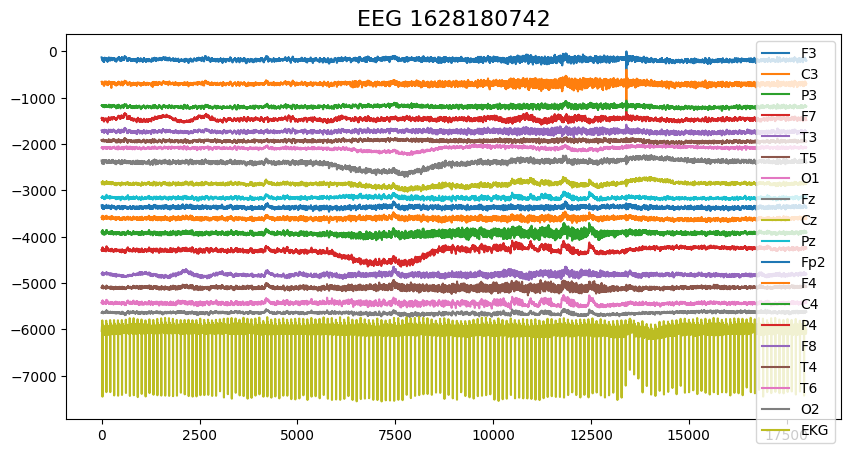

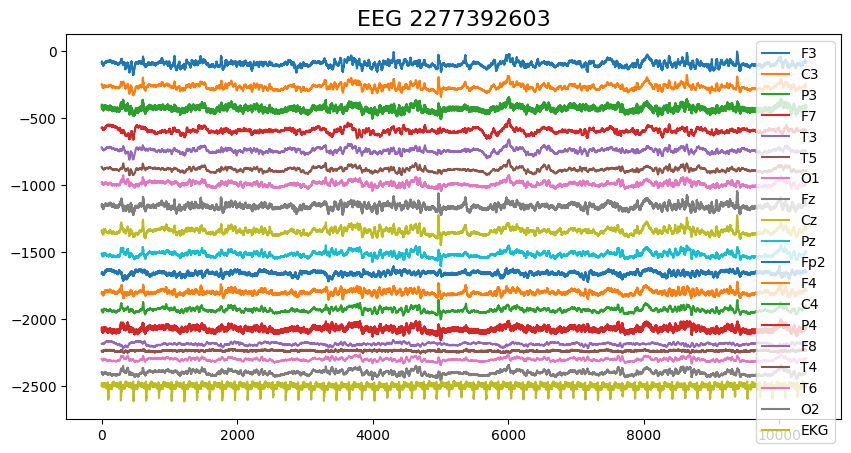

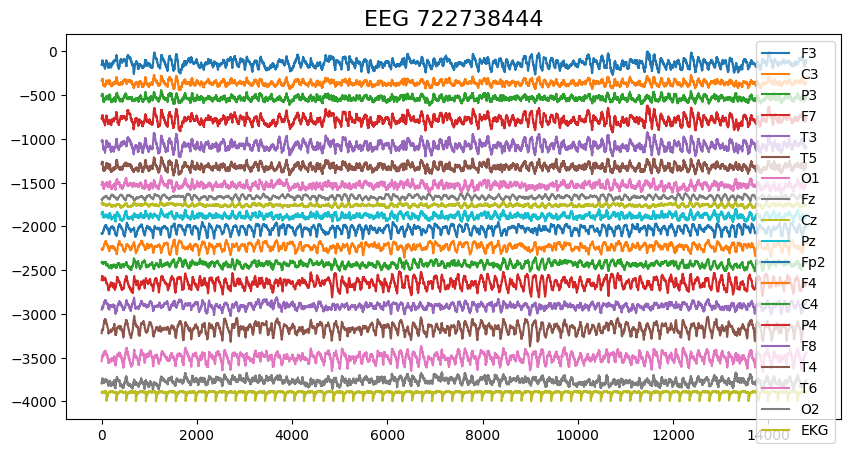

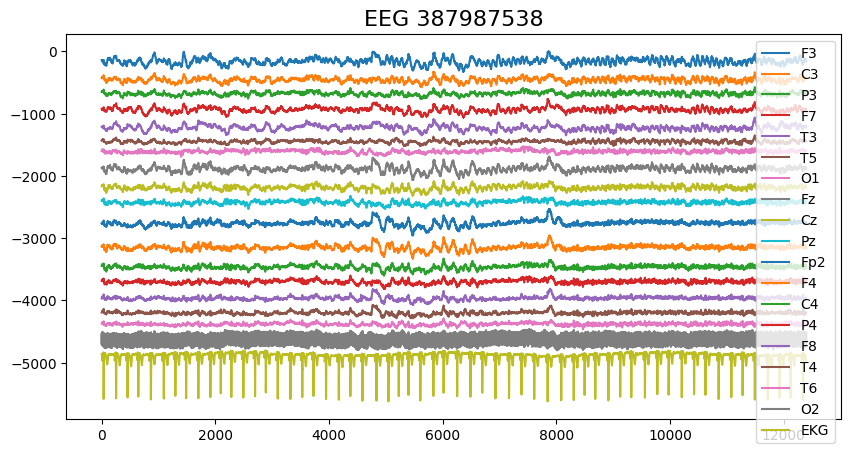

Processing 17089 eeg parquets... 100 , 200 , 300 , 400 , 500 , 600 , 700 , 800 , 900 , 1000 , 1100 , 1200 , 1300 , 1400 , 1500 , 1600 , 1700 , 1800 , 1900 , 2000 , 2100 , 2200 , 2300 , 2400 , 2500 , 2600 , 2700 , 2800 , 2900 , 3000 , 3100 , 3200 , 3300 , 3400 , 3500 , 3600 , 3700 , 3800 , 3900 , 4000 , 4100 , 4200 , 4300 , 4400 , 4500 , 4600 , 4700 , 4800 , 4900 , 5000 , 5100 , 5200 , 5300 , 5400 , 5500 , 5600 , 5700 , 5800 , 5900 , 6000 , 6100 , 6200 , 6300 , 6400 , 6500 , 6600 , 6700 , 6800 , 6900 , 7000 , 7100 , 7200 , 7300 , 7400 , 7500 , 7600 , 7700 , 7800 , 7900 , 8000 , 8100 , 8200 , 8300 , 8400 , 8500 , 8600 , 8700 , 8800 , 8900 , 9000 , 9100 , 9200 , 9300 , 9400 , 9500 , 9600 , 9700 , 9800 , 9900 , 10000 , 10100 , 10200 , 10300 , 10400 , 10500 , 10600 , 10700 , 10800 , 10900 , 11000 , 11100 , 11200 , 11300 , 11400 , 11500 , 11600 , 11700 , 11800 , 11900 , 12000 , 12100 , 12200 , 12300 , 12400 , 12500 , 12600 , 12700 , 12800 , 12900 , 13000 , 13100 , 13200 , 13300 , 13400 , 135

In [9]:
# trainsform eeg data from parquet to numpy and store them according to eeg id
import sys
sys.path.append('/kaggle/input/my_modules')
from kaggle.input.my_modules import save_pkl
DISPLAY = 4
EEG_IDS = train.eeg_id.unique()
SOURCE_PATH = './kaggle/input/hms-harmful-brain-activity-classification/train_eegs'
TARGET_PATH = './kaggle/input/processed_data/train_eegs2'
for i,eeg_id in enumerate(EEG_IDS):
    if (i%100==0)&(i!=0): print(i,', ',end='') 
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{SOURCE_PATH}/{eeg_id}.parquet', display=i<DISPLAY)                  
    if i==DISPLAY:
        print(f'Processing {train.eeg_id.nunique()} eeg parquets... ',end='')
    save_pkl(data,f'{TARGET_PATH}/{eeg_id}.pkl')

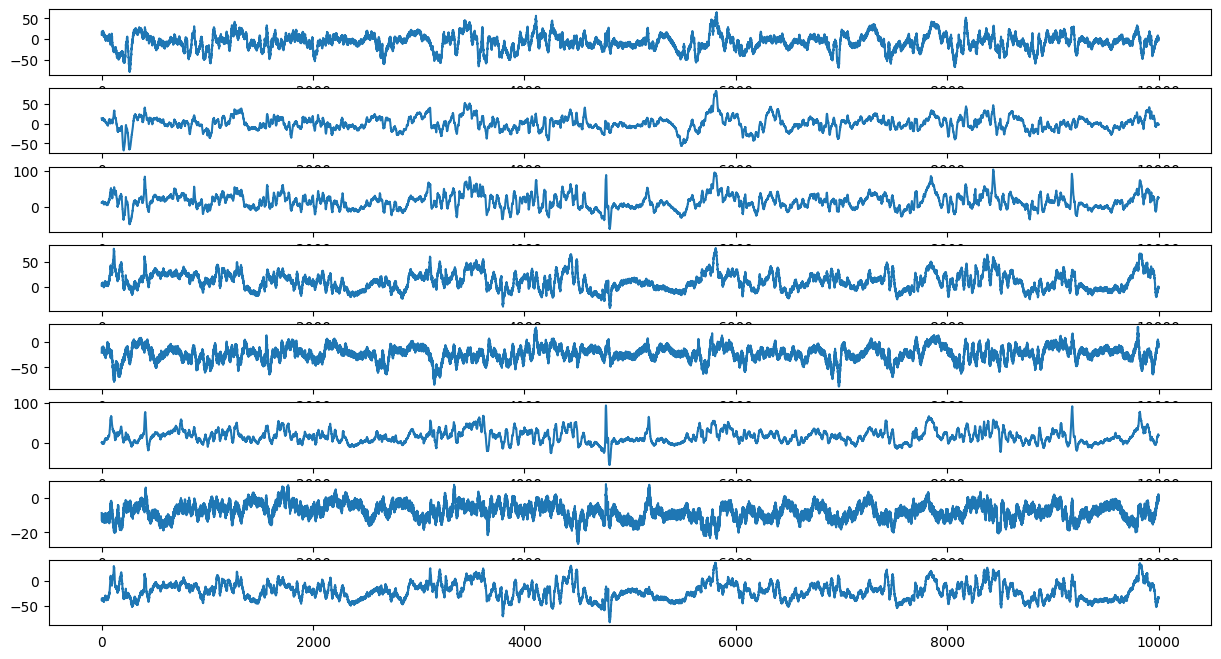

In [30]:
id = train[train["seizure_vote"]==0]["eeg_id"].iloc[1]
eeg = all_eegs[id]
fig, ax = plt.subplots(8,1,figsize=(15,8))
for i in range(8):
    ax[i].plot(eeg[:,i])
plt.show()

# Deduplicate Train EEG Id

In [9]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

In [21]:
# LOAD TRAIN 
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

train = df.groupby('eeg_id')[['patient_id']].agg('first')

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
train = train.loc[train.eeg_id.isin(EEG_IDS)]
print('Train Data with unique eeg_id shape:', train.shape )
train.head()

Train Data with unique eeg_id shape: (17089, 9)


,eeg_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


# Butter Low-Pass Filter

In [18]:
from scipy.signal import butter, lfilter

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

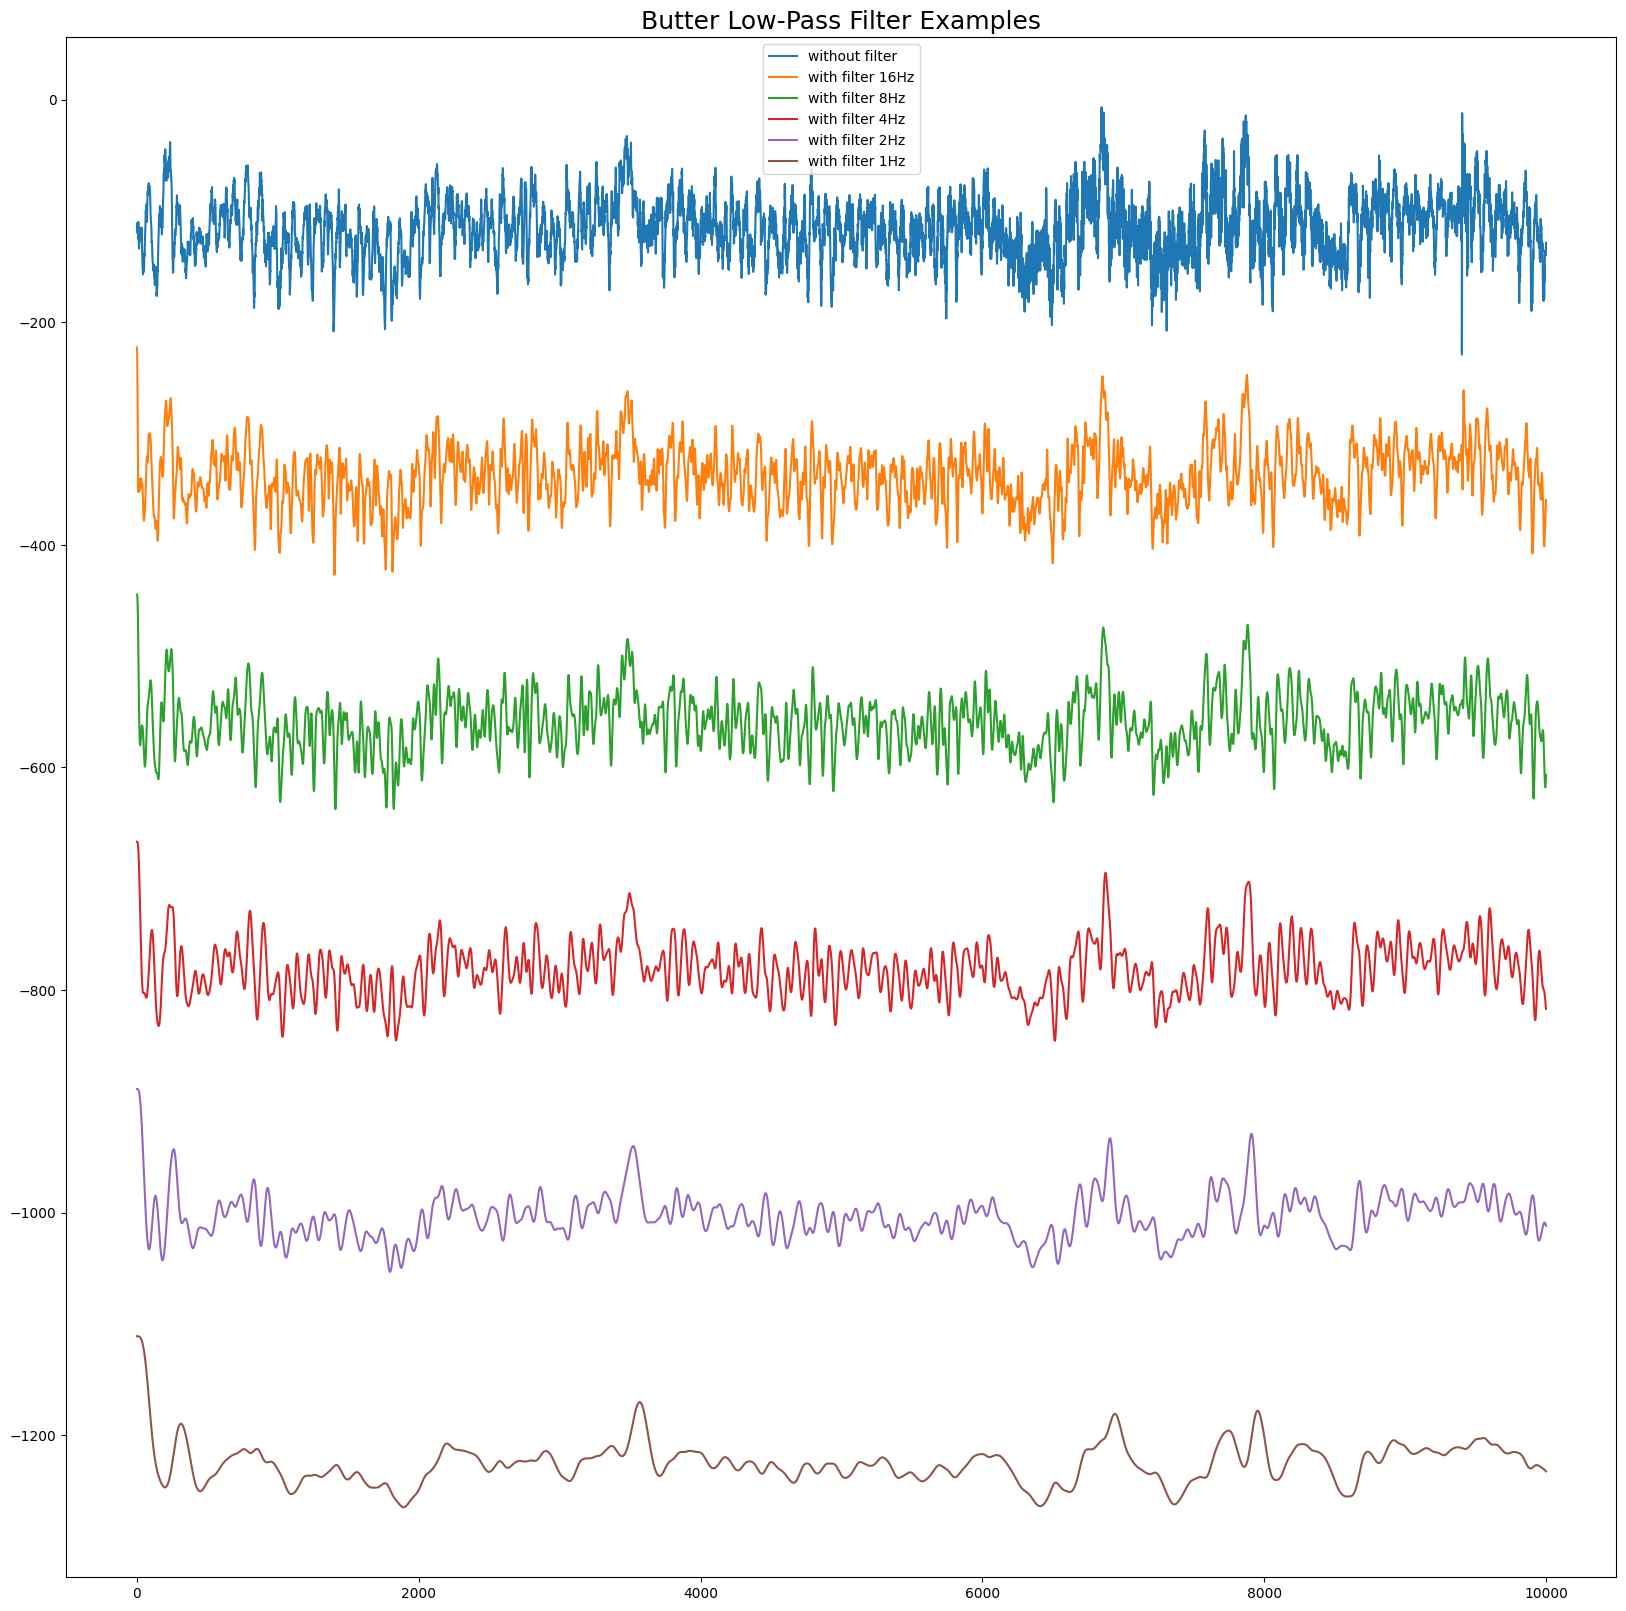

In [19]:
FREQS = [1,2,4,8,16][::-1]
x = [all_eegs[EEG_IDS[0]][:,0]]
for k in FREQS:
    x.append( butter_lowpass_filter(x[0], cutoff_freq=k) )

plt.figure(figsize=(20,20))
plt.plot(range(10_000),x[0], label='without filter')
for k in range(1,len(x)):
    plt.plot(range(10_000),x[k]-k*(x[0].max()-x[0].min()), label=f'with filter {FREQS[k-1]}Hz')
plt.legend()
plt.title('Butter Low-Pass Filter Examples',size=18)
plt.show()

# Dataset class

In [9]:
import os
from kaggle.input.my_modules.io.pkl import save_pkl, load_pkl
DATA_PATH = './kaggle/input/processed_data/train_eegs'
class EEGdataset:
    def __init__(self, 
                 DATA_PATH: str,):
        self.DATA_PATH = DATA_PATH
    def eeg_ids(self):
        eeg_ids = os.listdir(self.DATA_PATH)
        eeg_ids = [int(x.split('.')[0]) for x in eeg_ids]
        return eeg_ids
    def get(self, eeg_id):
        eeg = load_pkl(f'{self.DATA_PATH}/{eeg_id}.pkl')
        return eeg

In [10]:
eeg_dataset = EEGdataset(DATA_PATH)

In [11]:
id = eeg_dataset.eeg_ids()[0]
eeg = eeg_dataset.get(id)

# Data Loader

In [ ]:
import tensorflow as tf

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
import tensorflow as tf

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, 
                 data, 
                 batch_size=32, 
                 shuffle=False, 
                 eegs=all_eegs, 
                 mode='train',
                 downsample=5): 

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.eegs = eegs
        self.mode = mode
        self.downsample = downsample
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X[:,::self.downsample,:], y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
    
        X = np.zeros((len(indexes),10_000,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        
        sample = np.zeros((10_000,X.shape[-1]))
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]      
            data = self.eegs[row.eeg_id]
            
            # FEATURE ENGINEER
            sample[:,0] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['T3']]
            sample[:,1] = data[:,FEAT2IDX['T3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,2] = data[:,FEAT2IDX['Fp1']] - data[:,FEAT2IDX['C3']]
            sample[:,3] = data[:,FEAT2IDX['C3']] - data[:,FEAT2IDX['O1']]
            
            sample[:,4] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['C4']]
            sample[:,5] = data[:,FEAT2IDX['C4']] - data[:,FEAT2IDX['O2']]
            
            sample[:,6] = data[:,FEAT2IDX['Fp2']] - data[:,FEAT2IDX['T4']]
            sample[:,7] = data[:,FEAT2IDX['T4']] - data[:,FEAT2IDX['O2']]
            
            # STANDARDIZE
            sample = np.clip(sample,-1024,1024)
            sample = np.nan_to_num(sample, nan=0) / 32.0
            
            # BUTTER LOW-PASS FILTER
            sample = butter_lowpass_filter(sample)
            
            X[j,] = sample
            if self.mode!='test':
                y[j] = row[TARGETS]
            
        return X,y

# Display Data Loader

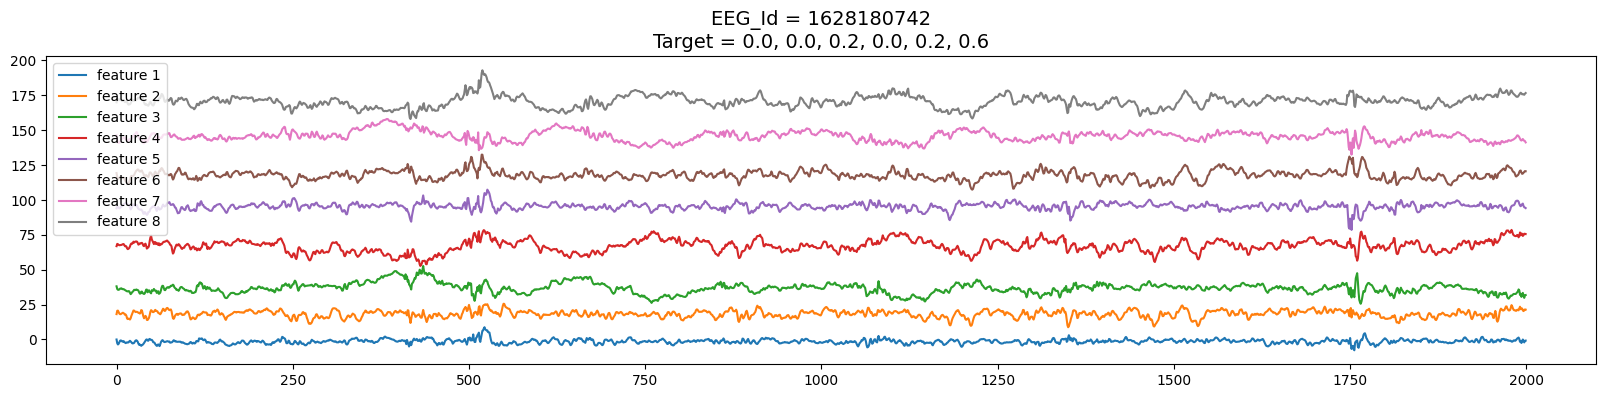

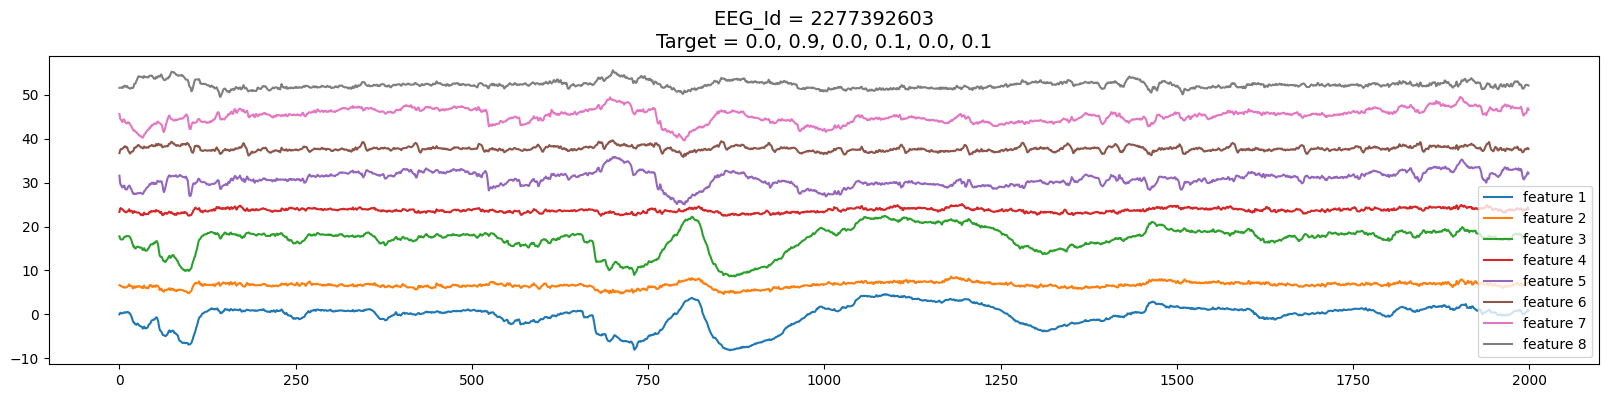

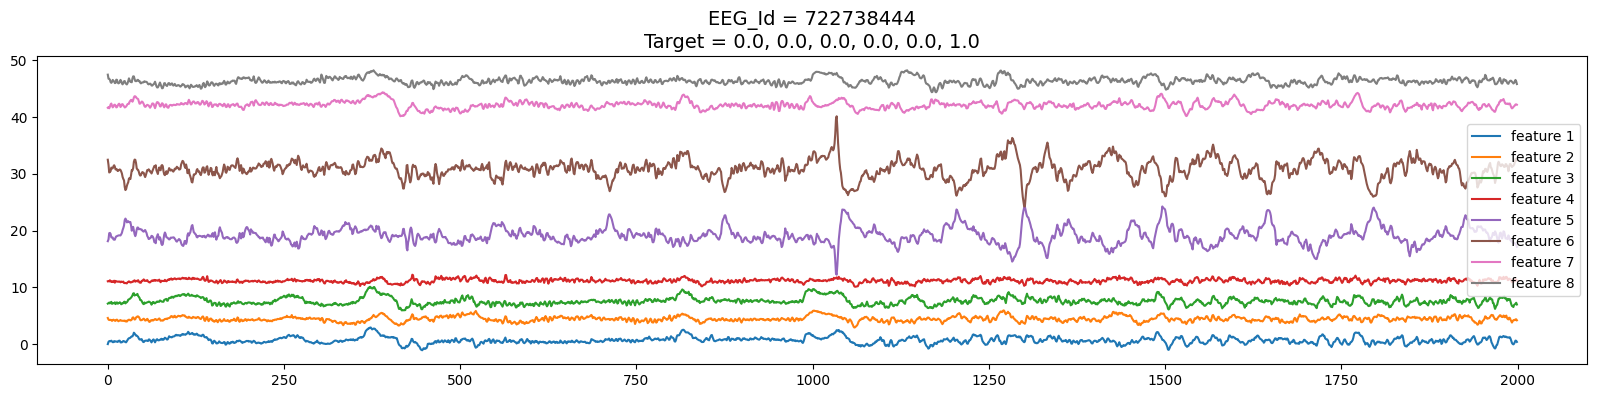

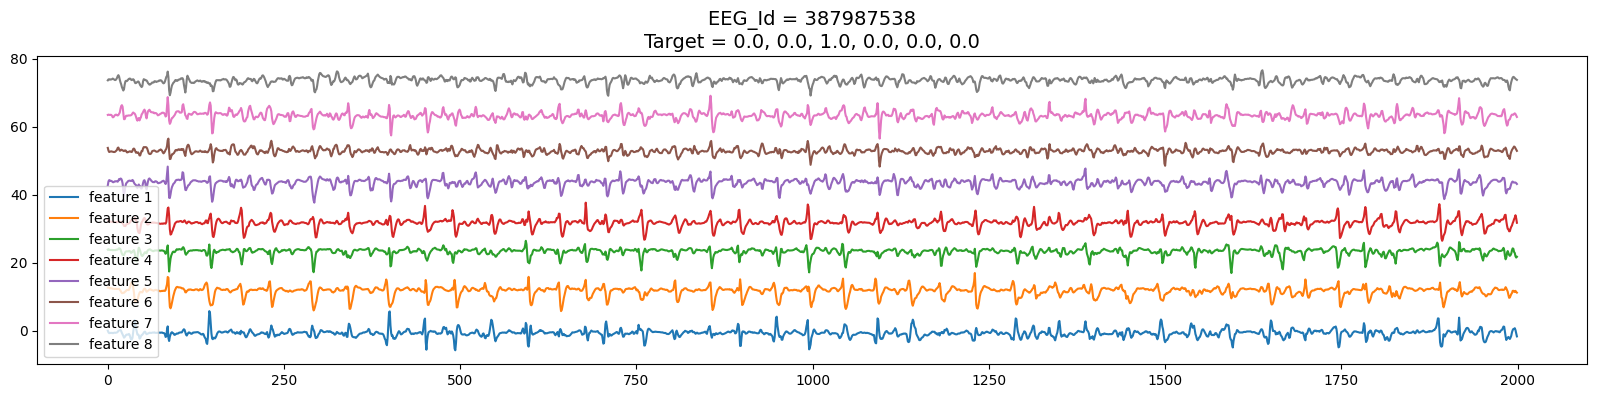

In [22]:
gen = DataGenerator(train, shuffle=False)

for x,y in gen:
    for k in range(4):
        plt.figure(figsize=(20,4))
        offset = 0
        for j in range(x.shape[-1]):
            if j!=0: offset -= x[k,:,j].min()
            plt.plot(range(2_000),x[k,:,j]+offset,label=f'feature {j+1}')
            offset += x[k,:,j].max()
        tt = f'{y[k][0]:0.1f}'
        for t in y[k][1:]:
            tt += f', {t:0.1f}'
        plt.title(f'EEG_Id = {EEG_IDS[k]}\nTarget = {tt}',size=14)
        plt.legend()
        plt.show()
    break

# Initialize GPUs

In [23]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1: 
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

TensorFlow version = 2.13.0
Using 2 GPUs


In [24]:
# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

Mixed precision enabled


# Build WaveNet Model

In [25]:
# TRAIN SCHEDULE
def lrfn(epoch):
        return [1e-3,1e-3,1e-4,1e-4,1e-5][epoch]
LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
EPOCHS = 5

In [26]:
from tensorflow.keras.layers import Input, Dense, Multiply, Add, Conv1D, Concatenate

def wave_block(x, filters, kernel_size, n):
    dilation_rates = [2**i for i in range(n)]
    x = Conv1D(filters = filters,
               kernel_size = 1,
               padding = 'same')(x)
    res_x = x
    for dilation_rate in dilation_rates:
        tanh_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same', 
                          activation = 'tanh', 
                          dilation_rate = dilation_rate)(x)
        sigm_out = Conv1D(filters = filters,
                          kernel_size = kernel_size,
                          padding = 'same',
                          activation = 'sigmoid', 
                          dilation_rate = dilation_rate)(x)
        x = Multiply()([tanh_out, sigm_out])
        x = Conv1D(filters = filters,
                   kernel_size = 1,
                   padding = 'same')(x)
        res_x = Add()([res_x, x])
    return res_x

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Jan-2024/wave-model.png)

In [27]:
def build_model():
        
    # INPUT 
    inp = tf.keras.Input(shape=(2_000,8))
    
    ############
    # FEATURE EXTRACTION SUB MODEL
    inp2 = tf.keras.Input(shape=(2_000,1))
    x = wave_block(inp2, 8, 3, 12)
    x = wave_block(x, 16, 3, 8)
    x = wave_block(x, 32, 3, 4)
    x = wave_block(x, 64, 3, 1)
    model2 = tf.keras.Model(inputs=inp2, outputs=x)
    ###########
    
    # LEFT TEMPORAL CHAIN
    x1 = model2(inp[:,:,0:1])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,1:2])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z1 = tf.keras.layers.Average()([x1,x2])
    
    # LEFT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,2:3])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,3:4])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z2 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT PARASAGITTAL CHAIN
    x1 = model2(inp[:,:,4:5])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,5:6])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z3 = tf.keras.layers.Average()([x1,x2])
    
    # RIGHT TEMPORAL CHAIN
    x1 = model2(inp[:,:,6:7])
    x1 = tf.keras.layers.GlobalAveragePooling1D()(x1)
    x2 = model2(inp[:,:,7:8])
    x2 = tf.keras.layers.GlobalAveragePooling1D()(x2)
    z4 = tf.keras.layers.Average()([x1,x2])
    
    # COMBINE CHAINS
    y = tf.keras.layers.Concatenate()([z1,z2,z3,z4])
    y = tf.keras.layers.Dense(64, activation='relu')(y)
    y = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(y)
    
    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=y)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()
    model.compile(loss=loss, optimizer = opt)
    
    return model

# Train Group KFold

In [49]:
%reload_ext tensorboard
%tensorboard --logdir=logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Address already in use
Port 6006 is in use by another program. Either identify and stop that program, or start the server with a different port.

In [50]:
VERBOSE = 1
FOLDS_TO_TRAIN = 5
if not os.path.exists('WaveNet_Model'):
    os.makedirs('WaveNet_Model')

from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc
TRAIN_MODEL = True
all_oof = []; all_oof2 = []; all_true = []
gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=32)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=64, mode='valid')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)
    
    # TRAIN MODEL
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if TRAIN_MODEL:
        tensorboard_callback = tf.keras.callbacks.TensorBoard(f"logs/fold{i}")
        model.fit(train_gen, verbose=VERBOSE,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR,tensorboard_callback])
        model.save_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    
    # WAVENET OOF
    oof = model.predict(valid_gen, verbose=VERBOSE)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)
    
    # TRAIN MEAN OOF
    y_train = train.iloc[train_index][TARGETS].values
    y_valid = train.iloc[valid_index][TARGETS].values
    oof = y_valid.copy()
    for j in range(6):
        oof[:,j] = y_train[:,j].mean()
    oof = oof / oof.sum(axis=1,keepdims=True)
    all_oof2.append(oof)
    
    del model, oof, y_train, y_valid
    gc.collect()
    
    if i==FOLDS_TO_TRAIN-1: break
    
all_oof = np.concatenate(all_oof)
all_oof2 = np.concatenate(all_oof2)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/5
428/428 [==============================] - 367s 379ms/step - loss: 1.0840 - val_loss: 0.9913 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/5
428/428 [==============================] - 110s 257ms/step - loss: 0.8303 - val_loss: 0.8321 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
Epoch 3/5
428/428 [==============================] - 110s 257ms/step - loss: 0.6757 - val_loss: 0.8254 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0001.
Epoch 4/5
428/428 [==============================] - 111s 260ms/step - loss: 0.6580 - val_loss: 0.8207 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 1e-05.
Epoch 5/5
165/428 [==========>...................] - ETA: 1:01 - loss: 0.6361

KeyboardInterrupt: 

# CV Score for WaveNet

In [66]:
solution = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
submission = pd.DataFrame({'id': range(3), 'ham': [0, 0.5, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.9, 0, 0]})
score(solution, submission, 'id')

0.0

In [45]:
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with WaveNet Raw EEG =',cv)

CV Score with WaveNet Raw EEG = 0.8107760694216857


# CV Score using Train Means

In [46]:
oof = pd.DataFrame(all_oof2.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score with Train Means =',cv)

CV Score with Train Means = 1.2641160568651757


# Submit to Kaggle LB

In [93]:
solution = pd.DataFrame({'id': range(3), 'ham': [0.19, 0.3, 0.5], 'spam': [0.11, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
submission = pd.DataFrame({'id': range(3), 'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
score(solution, submission, 'id')

0.00024613128161370357

In [112]:
from scipy.special import kl_div, rel_entr
solution = pd.DataFrame({'ham': [0.19, 0.3, 0.5], 'spam': [0.11, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
submission = pd.DataFrame({'ham': [0.2, 0.3, 0.5], 'spam': [0.1, 0.5, 0.5], 'other': [0.7, 0.2, 0]})
sol = solution.iloc[:].to_numpy()
sub = submission.iloc[:].to_numpy()
print(kl_div(sol,sub))
print(rel_entr(sol,sub))

[[0.00025427 0.00048412 0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[-0.00974573  0.01048412  0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]


In [47]:
del all_eegs, train; gc.collect()
test = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
print('Test shape:',test.shape)
test.head()

Test shape: (1, 3)


,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


Processing Test EEG parquets...



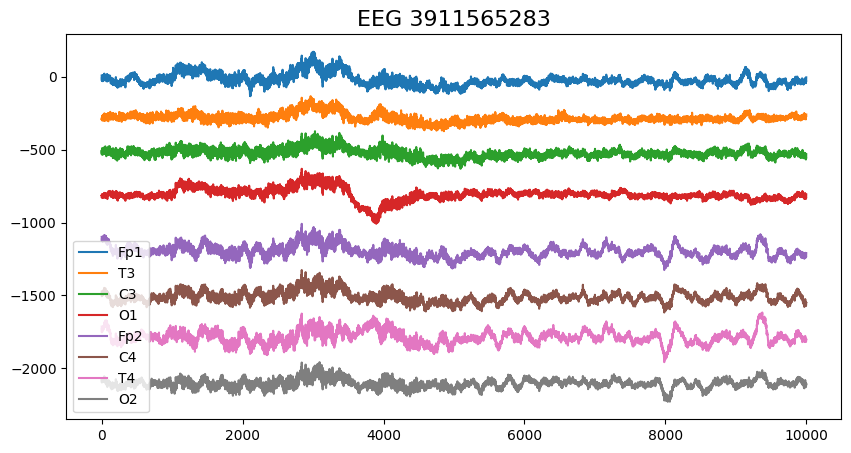

In [53]:
all_eegs2 = {}
DISPLAY = 1
EEG_IDS2 = test.eeg_id.unique()
PATH2 = '/kaggle/input/hms-harmful-brain-activity-classification/test_eegs/'

print('Processing Test EEG parquets...'); print()
for i,eeg_id in enumerate(EEG_IDS2):
        
    # SAVE EEG TO PYTHON DICTIONARY OF NUMPY ARRAYS
    data = eeg_from_parquet(f'{PATH2}{eeg_id}.parquet', i<DISPLAY)
    all_eegs2[eeg_id] = data

In [54]:
# INFER MLP ON TEST
preds = []
model = build_model()
test_gen = DataGenerator(test, shuffle=False, batch_size=64, eegs=all_eegs2, mode='test')

print('Inferring test... ',end='')
for i in range(FOLDS_TO_TRAIN):
    print(f'fold {i+1}, ',end='')
    if TRAIN_MODEL:
        model.load_weights(f'WaveNet_Model/WaveNet_fold{i}.h5')
    else:
        model.load_weights(f'/kaggle/input/brain-eegs/WaveNet_Model/WaveNet_fold{i}.h5')
    pred = model.predict(test_gen, verbose=0)
    preds.append(pred)
pred = np.mean(preds,axis=0)
print()
print('Test preds shape',pred.shape)

Inferring test... fold 1, fold 2, fold 3, fold 4, fold 5, 
Test preds shape (1, 6)


In [55]:
# CREATE SUBMISSION.CSV
from IPython.display import display

sub = pd.DataFrame({'eeg_id':test.eeg_id.values})
sub[TARGETS] = pred
sub.to_csv('submission.csv',index=False)
print('Submission shape',sub.shape)
display( sub.head() )

# SANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
print('Sub row 0 sums to:',sub.iloc[0,-6:].sum())

Submission shape (1, 7)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.047583,0.0323,0.001257,0.112728,0.105966,0.700166


Sub row 0 sums to: 1.0000000086147338
